# 모듈 호출

In [1]:
# 파이토치 불러오기
import torch
import torch.nn as nn

# 데이터셋 불러오기
from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10

# 데이터 로더
from torch.utils.data.dataloader import DataLoader

# 최적화 알고리즘
from torch.optim import optimizer

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

In [2]:
# 시드 고정
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

# 데이터 호출

In [4]:
# 데이터 호출(CIFAR 10)
path = '/home/helpme/data/CIFAR10'


train_data = CIFAR10(
    root = path,
    train=True,
    download=True,
    transform=transform
)

test_data = CIFAR10(
    root = path,
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


# 이미지 정규화

In [5]:
# 이미지 정규화
imgs = np.array([img.numpy() for img, _ in train_data])
print(f'img shape : {imgs.shape}')

img shape : (50000, 3, 224, 224)


In [6]:
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

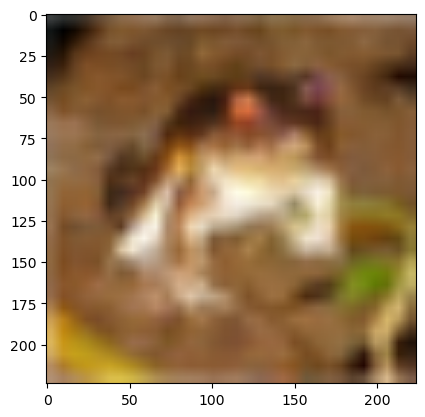

In [7]:
# frog로 보임
plt.imshow(imgs[0].transpose(1,2,0))

# 데이터 로더

In [8]:
batch_size = 64
num_workers = 4

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

In [9]:
print(train_dataloader.dataset)
print(f'Total {len(train_dataloader)} images in 1 batch')

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/helpme/data/CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Total 782 images in 1 batch


# 모델 생성

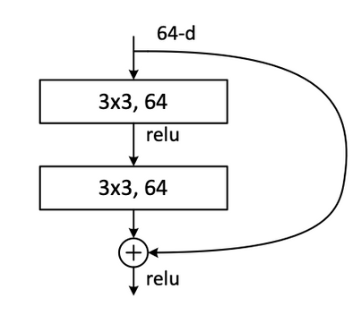

In [10]:
# 2-layer block(Basic Block)
# 얕은 resnet에 사용된 블록

class BasicBlock(nn.Module):
    expansion_factor = 1 
    def __init__(self, in_channels:int, out_channels:int, stride = 1, projection = None) -> None:
        super().__init__()

        self.residual = nn.Sequential(
            # 3*3 kernel, size 유지를 위해 1 padding, batch norm을 사용하기 때문에 bias False
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels), # batch norm
            nn.ReLU(inplace=True), # ReLU

            # 앞선 층에서 받은 out_channel 을 input 으로 사용,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            # residual mapping 이후 ReLU를 사용하기에 여기서는 생략
        )

        # demension increasing이 있는 경우 projection shortcut 사용
        # increasing 이 없을 경우에는 그저 none 처리
        self.projection = projection 

        # 마지막 shortcut connection을 위해 relu를 사용
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        identity = x # identity mapping 
        
        x = self.residual(x)
        
        # demension increasing 이 있는 경우 사용
        # 없을 때(모델 구조상 실선)에는 그저 None
        # 있을 때에는(모델 구조상 점선)에는 x 입력
        if self.projection is not None: # 점선일 경우
            # projection 모듈을 사용해서 해상도를 맞춰줌(ResNet class에서 구현)
            shortcut = self.projection(x) 
        else: # 실선일 경우
            # 원래 identity  값을 그대로 사용
            shortcut = identity

        # skip connection
        x = self.relu(x+shortcut) # 최종적으로 relu 사용

        return x

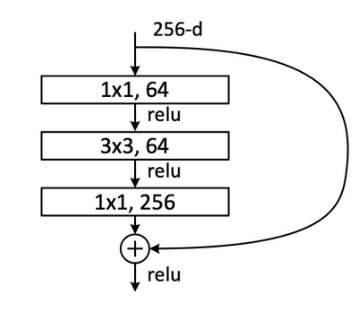

In [11]:
# 3-layer block(BottleNeck Block)
# 모든 layer의 convolution 다음, 활성화 함수 이전에는 batch normalization 적용
class BottleNeck(nn.Module):
    expansion_factor = 4 # 마지막 차원 복구를 위한 expansion factor
    def __init__(self, in_channels:int, out_channels:int, stride = 1, projection=None):
        super().__init__()
        # 1*1, 64
        self.residual = nn.Sequential(
            # 1*1, batch norm에 bias가 포함돼있기 때문에 False 설정
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=1, stride=stride, bias=False), 
            nn.BatchNorm2d(num_features=out_channels), # conv 다음이면서 activation 전이기 때문에 batch norm
            nn.ReLU(inplace=True),

        # 3*3, 64
            # 3*3, input 채널은 이전 레이어의 output에서 받아옴, batch norm에 bias가 포함돼있기 때문에 False 설정, 3*3 이기 때문에 size 유지를 위해 padding 1
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(num_features=out_channels), # conv 다음이면서 activation 전이기 때문에 batch norm
            nn.ReLU(inplace=True),
        
        # 1*1, 256
            # 1*1, input 채널은 이전 레이어의 output, batch norm에 bias가 포함돼있기 때문에 False 설정, expansion factor(4)를 통해 원래 input size로 복귀
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels * self.expansion_factor, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels * self.expansion_factor),
            # ReLU 생략
        )
        
        # demension increasing이 있는 경우 projection shortcut 사용
        # increasing 이 없을 경우에는 그저 none 처리
        self.projection = projection 

        # add를 위한 relu
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        residual = self.residual(x)

        # demension increasing 이 있는 경우 사용
        # 없을 때(모델 구조상 실선)에는 그저 None
        # 있을 때에는(모델 구조상 점선)에는 x 입력
        if self.projection is not None: # 점선일 경우
            # projection 모듈을 사용해서 해상도를 맞춰줌(ResNet class에서 구현)
            shortcut = self.projection(x) 
        else: # 실선일 경우
            # 원래 identity  값을 그대로 사용
            shortcut = x
            
       # skip connection
        x = self.relu(residual+shortcut) # 최종적으로 relu 사용

        return x

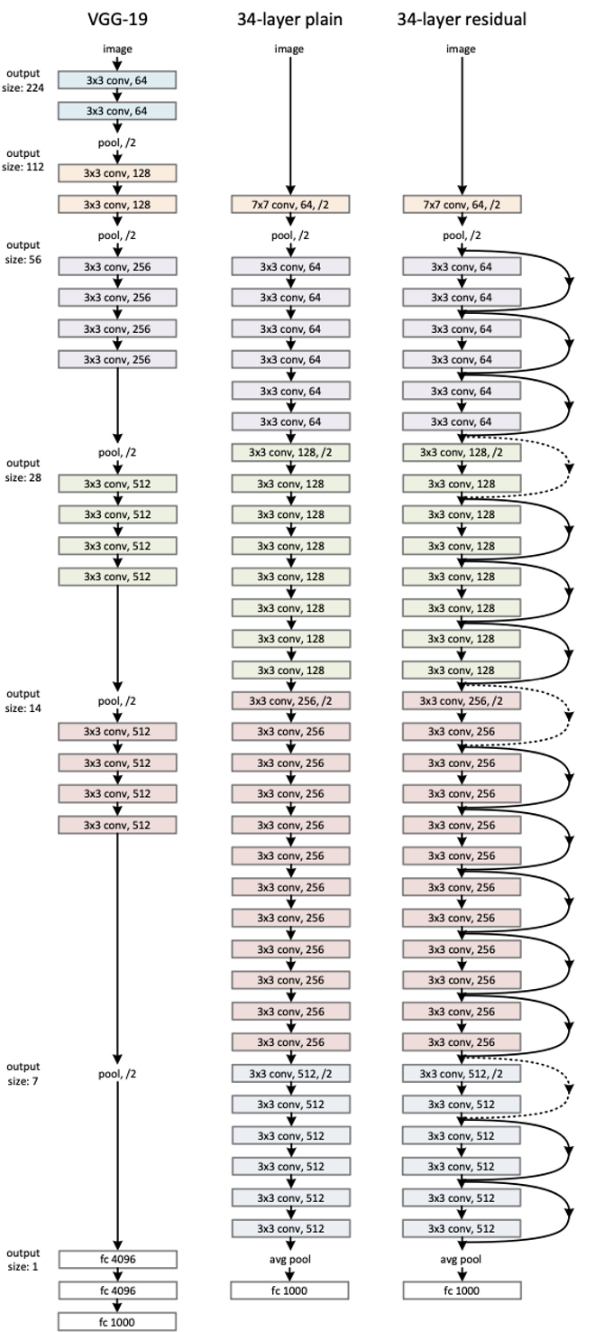

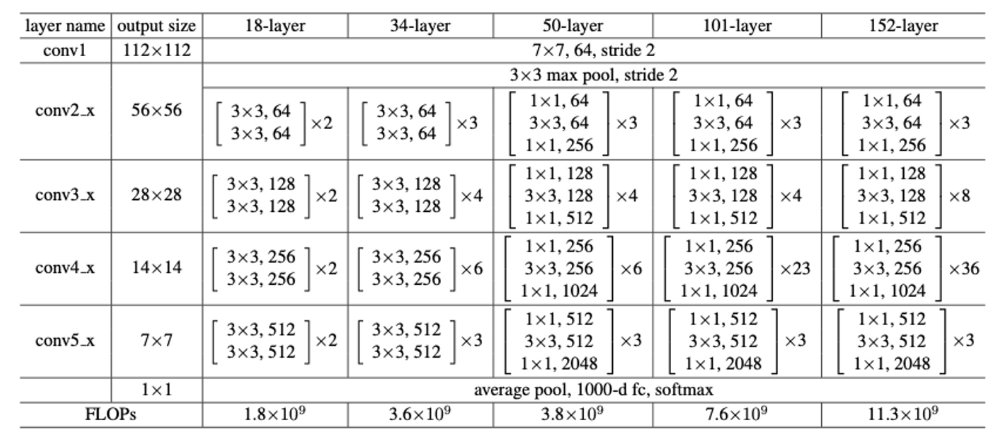

In [12]:
class ResNet(nn.Module):
    # 34~ 152 층을 일일히 쌓을 순 없겠져?
    # block 변수를 사용하여 50층 미만일 때 basic block을 사용하고, 50층 이상일땐 bottelneck block을 사용하게 구성
    # 이를 위해 block(basic / bottleneck), input_channels, 
    def make_layers(self, block, inner_channels, num_blocks, stride=1): 
        # resnet은 크기를 줄일 때 pooling을 쓰지 않고 stride를 2로 가져가는 방식을 사용함
        # 크기가 작아질 때는 연산량을 일치시키기 위해 채널이 2배가 됨
        # 즉, stride가 1이 아니거나, input channel이 늘어나는 경우 projection을 통해 channel을 맞춰줘야함
        # 단, 최초 7*7 연산을 하는 conv1의 경우 stride가 2라 제외

        # 모델의 점선, channel 변화가 일어나거나 stride가 2일 때만 projection이 발생 
        if stride != 1 or self.in_channels != inner_channels * block.expansion_factor:
            projection = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channels, out_channels=inner_channels * block.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(inner_channels * block.expansion_factor)
            )
        # channel 변화가 없거나 stride가 1일 경우엔 아무런 projection 변화가 없음
        else :
            projection = None
            

        layer = [] # 실제 layer를 쌓아 담을 list 생성
        
        # projection이 일어나야할 최초 블럭 먼저 담아주기
        layer += [block(self.in_channels, inner_channels, stride, projection)]
        
        # 각 블럭에 입력될 channels 정의해주기
        self.in_channels = inner_channels * block.expansion_factor
        
        # 나머지 블럭들 이어 붙여주기
        for i in range(1, num_blocks): # 앞서 정의된 첫 블럭이 있기 때문에 1부터 range 시작
            layer += [block(self.in_channels, inner_channels)]
        
        return nn.Sequential(*layer) # index가 존재하는 개체를 * 표시를 붙여 함수에 입력하면 순서대로 입력됨


    def __init__(self, block, num_block_list:list, num_classes = 10) -> None:
        # block : 50 계층 미만에는 basic block, 50층이 넘어가면 Bottlneck 구조 사용
        # num_block_list = conv2, conv3, conv4, conv5 로 무엇을 받을지 list로 받음

        super().__init__()

        self.in_channels = 64
            
        self.conv1 = nn.Sequential(
            # 최초 7*7 conv 사용, stride 2
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False), 
            nn.BatchNorm2d(64), 
            nn.ReLU(inplace=True),
            # 3*3 maxpool, stride 2
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.conv2 = self.make_layers(block, 64, num_block_list[0], stride=1)
        self.conv3 = self.make_layers(block, 128, num_block_list[1], stride=2)
        self.conv4 = self.make_layers(block, 256, num_block_list[2], stride=2)
        self.conv5 = self.make_layers(block, 512, num_block_list[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # global average pooling
        
        # fully connected
        self.fc = nn.Linear(in_features=512 * block.expansion_factor, out_features=num_classes)

        # softmax : cross entropy loss 안에 있기 때문에 생략.

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = self.avgpool(x)
        
        x = torch.flatten(x, 1)

        x = self.fc(x)

        return x


In [13]:
class Model:
    def resnet18(self):
        return ResNet(BasicBlock, [2, 2, 2, 2])

    def resnet34(self):
        return ResNet(BasicBlock, [3, 4, 6, 3])

    def resnet50(self):
        return ResNet(BottleNeck, [3, 4, 6, 3])

    def resnet101(self):
        return ResNet(BottleNeck, [3, 4, 23, 3])

    def resnet152(self):
        return ResNet(BottleNeck, [3, 8, 36, 3])

In [14]:
model = Model().resnet152()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
model.to(device)

Using cuda device


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): BottleNeck(
      (residual): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pro

# 모델 확인

In [15]:
from torchinfo import summary
summary(model, input_size=(batch_size,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 56, 56]          --
│    └─Conv2d: 2-1                       [64, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                  [64, 64, 112, 112]        128
│    └─ReLU: 2-3                         [64, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                    [64, 64, 56, 56]          --
├─Sequential: 1-2                        [64, 256, 56, 56]         --
│    └─BottleNeck: 2-5                   [64, 256, 56, 56]         --
│    │    └─Sequential: 3-1              [64, 256, 56, 56]         58,112
│    │    └─Sequential: 3-2              [64, 256, 56, 56]         16,896
│    │    └─ReLU: 3-3                    [64, 256, 56, 56]         --
│    └─BottleNeck: 2-6                   [64, 256, 56, 56]         --
│    │    └─Sequential: 3-4              [64, 256, 56, 56]         70,400

# 학습 loss, 최적화 알고리즘 확인

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

criterion.to(device=device)
model.to(device=device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): BottleNeck(
      (residual): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pro

# 학습 

In [17]:
# 학습
num_epochs = 10 # 에폭 설정

loss_arr = []
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_dataloader):  
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        output = model(images) # 모델 예측 시행
    
        # 예측에 따른 손실 계산 및 출력
        loss = criterion(output, labels)  

        # backward pass 
        optimizer.zero_grad() # 가중치 변화를 0으로 만들고
        loss.backward() # 역전파를 수행하고
        optimizer.step() # 가중치를 갱신

        running_loss += loss.item()
        loss_arr.append(loss.item())
        # 100번에 한번씩 loss 출력
        if i % 39 == 38: 
            print(f'Training epoch : {epoch+1}, [{i * len(images)} / {len(train_dataloader.dataset)}] ({100 * i / len(train_dataloader):0.0f}%), Loss : {running_loss/39:0.6f}')
            running_loss = 0.0

print('학습종료!')

Training epoch : 1, [2432 / 50000] (5%), Loss : 2.281976
Training epoch : 1, [4928 / 50000] (10%), Loss : 2.045661
Training epoch : 1, [7424 / 50000] (15%), Loss : 1.975217
Training epoch : 1, [9920 / 50000] (20%), Loss : 1.923054
Training epoch : 1, [12416 / 50000] (25%), Loss : 1.866131
Training epoch : 1, [14912 / 50000] (30%), Loss : 1.756197
Training epoch : 1, [17408 / 50000] (35%), Loss : 1.702852
Training epoch : 1, [19904 / 50000] (40%), Loss : 1.672028
Training epoch : 1, [22400 / 50000] (45%), Loss : 1.593063
Training epoch : 1, [24896 / 50000] (50%), Loss : 1.568677
Training epoch : 1, [27392 / 50000] (55%), Loss : 1.544681
Training epoch : 1, [29888 / 50000] (60%), Loss : 1.489355
Training epoch : 1, [32384 / 50000] (65%), Loss : 1.496424
Training epoch : 1, [34880 / 50000] (70%), Loss : 1.497861
Training epoch : 1, [37376 / 50000] (75%), Loss : 1.445402
Training epoch : 1, [39872 / 50000] (80%), Loss : 1.436691
Training epoch : 1, [42368 / 50000] (85%), Loss : 1.394969
Tr

# 학습 결과 loss 시각화

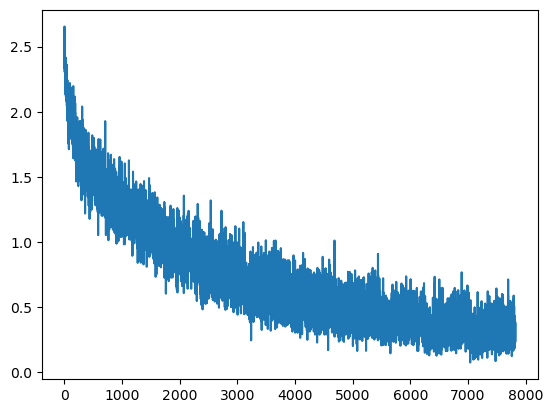

In [18]:
plt.plot(loss_arr)
plt.show()

# 테스트

In [19]:
# test 
model.eval() # drop out 같은 학습에만 필요하고 test에는 불필요한 층을 비활성화

# 클래스 개수대로 정답 개수, 총 개수 구하기
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


with torch.no_grad(): # gradient 연산을 멈춘 상태로 계산, 메모리 절약 및 연산속도 증가
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # 결과 예측
        outputs = model(images) # 모델 실행

        # 이미지가 가질 수 있는 라벨 중 가장 높은 확률과 인덱스(라벨)를 출력
        _, predicted = torch.max(outputs.data, dim=1) 

        # 라벨과 정답이 일치하는지 확인
        c = (predicted == labels).squeeze()

        # 한번에 배치 사이즈만큼 예측하기 때문에 batch_size 개수만큼 예측 결과가 나옴
        for i in range(len(data)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [20]:
# test 결과 확인
total_correct = 0
total = 0

for i in range(10):
    total_correct += class_correct[i]
    total += class_total[i]
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

print(f'Total accuracy : {100 * total_correct/total:0.2f}%')

Accuracy of airplane : 88 %
Accuracy of automobile : 92 %
Accuracy of  bird : 78 %
Accuracy of   cat : 89 %
Accuracy of  deer : 74 %
Accuracy of   dog : 63 %
Accuracy of  frog : 80 %
Accuracy of horse : 93 %
Accuracy of  ship : 90 %
Accuracy of truck : 95 %
Total accuracy : 85.03%
